In [15]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg
import math

In [16]:
class Gaussian:
    def __init__(self, width, amplitude, x0):
        self.width = width
        self.amplitude = amplitude
        self.x0 = x0
        
    def __call__(self, x):
        A = self.amplitude
        x0 = self.x0
        sigma = self.width
        return A*np.exp(-((x[0]-x0[0])**2 + (x[1]-x0[1])**2)/sigma**2)

In [34]:
class propagate:
    def __init__(self, Lx, Nx, Ly, Ny, Lz, Nz, k, a, b, K, init_f, non_f):
        self.Lx = Lx
        self.Nx = Nx
        self.Ly = Ly
        self.Ny = Ny
        self.Lz = Lz
        self.Nz = Nz
        self.k = k
        self.a = a
        self.b = b
        self.K = K
        self.non_f = non_f
        self.dz = Lz/Nz
        self.dx = Lx/Nx
        self.dy = Ly/Ny
        self.matrix = np.zeros([Nz, 2*Nx, 2*Ny])
        
        self.kx = 2*np.pi*np.fft.fftfreq(2*Nx, d=self.dx)
        self.ky = 2*np.pi*np.fft.fftfreq(2*Ny, d=self.dy)
        self.x = np.linspace(-Lx, Lx, 2*Nx)
        self.y = np.linspace(-Ly, Ly, 2*Ny)
        
        E = np.zeros([2*Nx, 2*Ny])
        for i in range(2*Nx):
            for j in range(2*Ny):
                x0 =(2*Lx)/(2*Nx-1)*i - Lx
                x1 =(2*Ly)/(2*Ny-1)*j - Ly
                E[i][j] = init_f([x0, x1])
        
        self.E = E
        self.matrix[0,:,:] = E
        
    def evolution(self):
        list_z =[]
        E = self.E
        list_z.append(np.abs(E)**2)
        
        for l in range(Nz-1):
            '''
            #solve for non-linear
            E = E*np.exp(self.dz*self.non_f(E))
            c = np.fft.fft2(E)*np.exp(-1j/(2*self.k)*(self.kx**2 + self.ky**2)*self.dz)
            E = np.fft.ifft2(c)
            '''
            #Linear
            Ek = np.fft.fft2(E)
            Ek *= np.exp(-1j/(2*self.k)*(self.kx**2 + self.ky**2)*self.dz)
            E = np.fft.ifft2(Ek)
            
            #Non-linear
            E += non_f(E)*self.dz
            '''
            
            #Putting into list
            list_z.append(np.abs(E)**2)
        
        list_z = np.asarray(list_z)
        self.matrix = list_z
        
        
        
        

[[[2.86957576e-25 2.89254318e-25 2.91560328e-25 ... 2.91560328e-25
   2.89254318e-25 2.86957576e-25]
  [2.89254318e-25 2.91569443e-25 2.93893909e-25 ... 2.93893909e-25
   2.91569443e-25 2.89254318e-25]
  [2.91560328e-25 2.93893909e-25 2.96236907e-25 ... 2.96236907e-25
   2.93893909e-25 2.91560328e-25]
  ...
  [2.91560328e-25 2.93893909e-25 2.96236907e-25 ... 2.96236907e-25
   2.93893909e-25 2.91560328e-25]
  [2.89254318e-25 2.91569443e-25 2.93893909e-25 ... 2.93893909e-25
   2.91569443e-25 2.89254318e-25]
  [2.86957576e-25 2.89254318e-25 2.91560328e-25 ... 2.91560328e-25
   2.89254318e-25 2.86957576e-25]]

 [[3.02578791e-25 3.02681145e-25 3.02886534e-25 ... 3.02886534e-25
   3.02681145e-25 3.02578791e-25]
  [3.05000561e-25 3.05103735e-25 3.05310767e-25 ... 3.05310767e-25
   3.05103735e-25 3.05000561e-25]
  [3.07432104e-25 3.07536100e-25 3.07744783e-25 ... 3.07744783e-25
   3.07536100e-25 3.07432104e-25]
  ...
  [3.07432104e-25 3.07536100e-25 3.07744783e-25 ... 3.07744783e-25
   3.07536

C:\Users\Hong\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
C:\Users\Hong\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


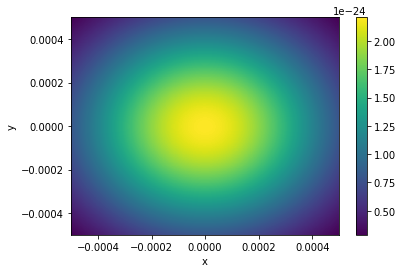

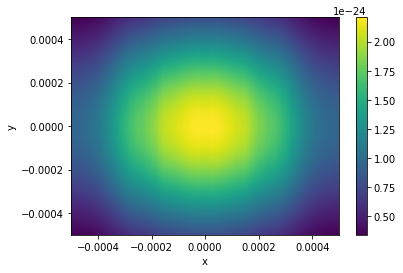

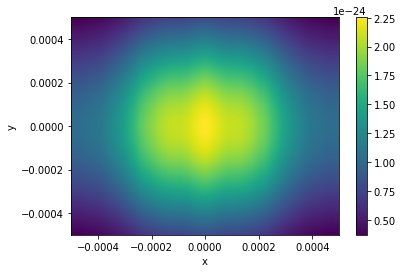

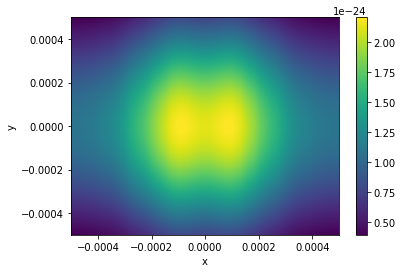

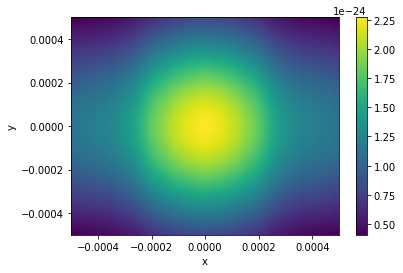

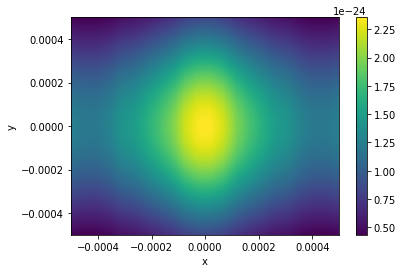

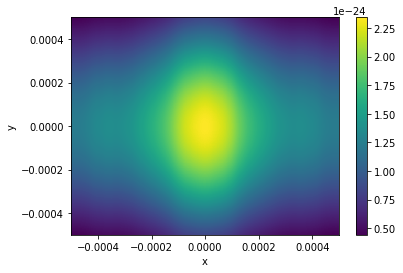

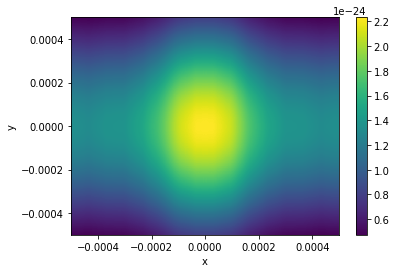

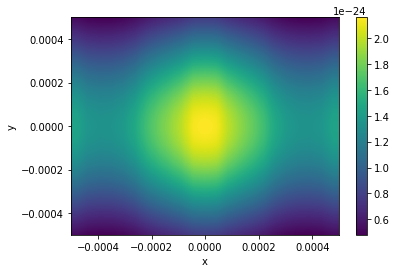

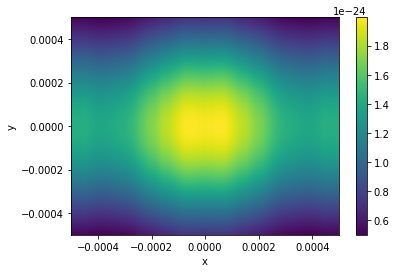

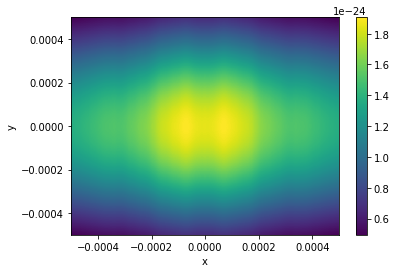

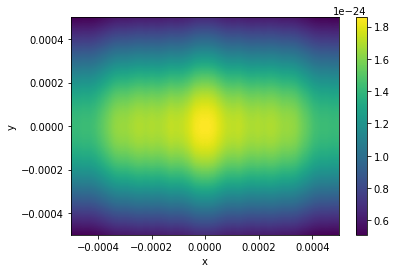

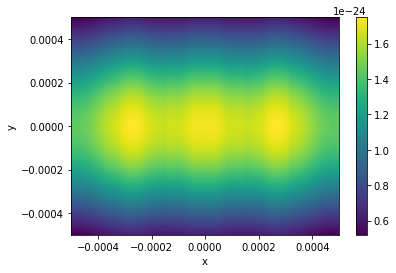

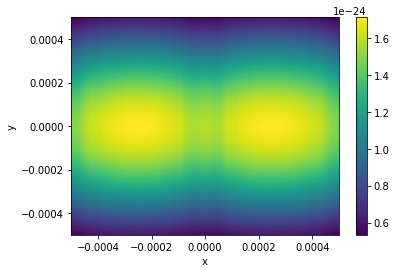

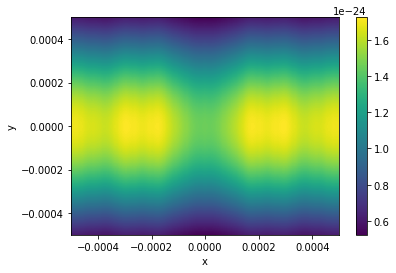

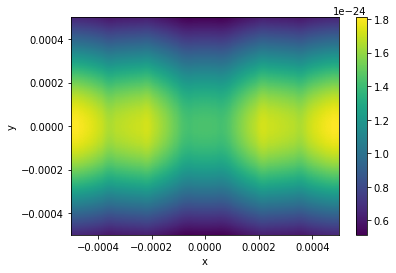

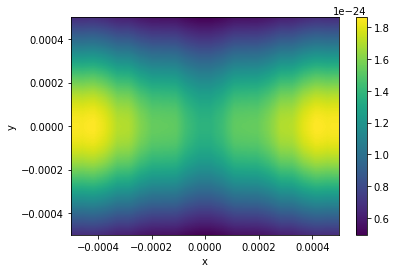

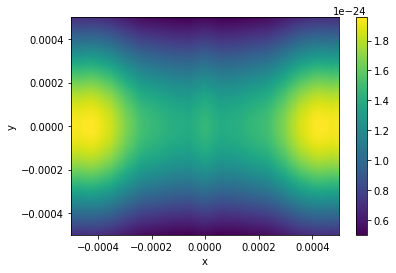

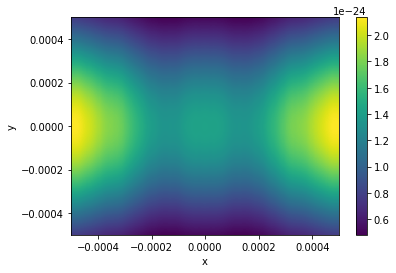

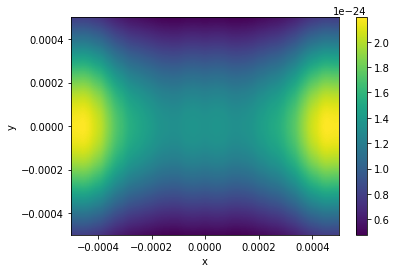

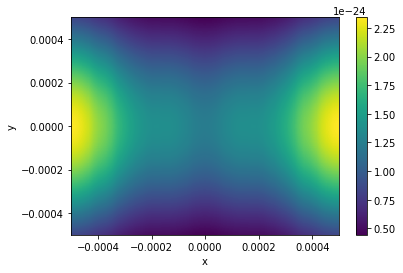

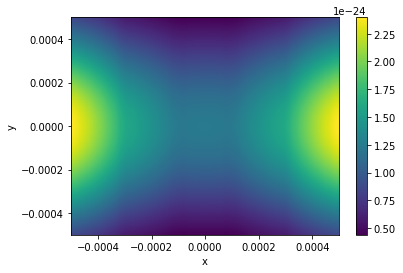

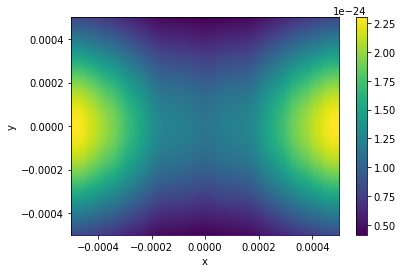

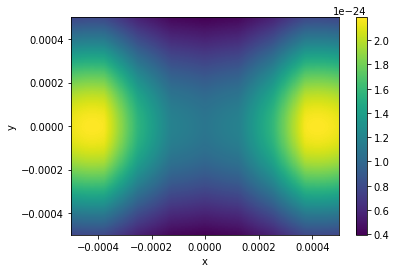

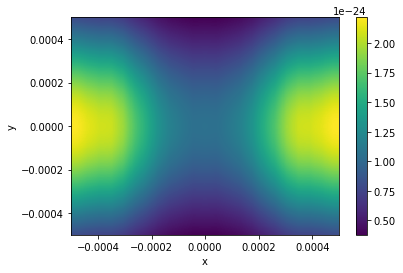

In [36]:
w0 = 0.7*1e-3
Pcr = 1.7*1e9
p = 10
Pin = p*Pcr
AMP = (2*Pin/(math.pi*w0**2))**(1/2)*1e-20
x0 = [0., 0.]

gauss = Gaussian(w0, AMP, x0)

Lx = 500*1e-6
Nx = 256
Ly = 500*1e-6
Ny = 256
Lz = 0.6
Nz = 256
k = 6/775*1e9
a = 34*1e-108 + 2*1e-16*1j
b = 3.25*1e-104
#a = 1e-40
#b = 1e-40
K = 7

init_f = gauss

E = np.zeros([2*Nx, 2*Ny])
for i in range(2*Nx):
    for j in range(2*Ny):
        x0 =(2*Lx)/(2*Nx - 1)*i - Lx
        x1 =(2*Ly)/(2*Ny - 1)*j - Ly
        E[i][j] = gauss([x0, x1])

def non_f(E):
    return a*np.abs(E)**2 - b*np.abs(E)**(2*K - 2)

Pro = propagate(Lx, Nx, Ly, Ny, Lz, Nz, k, a, b, K, init_f, non_f)
Pro.evolution()
print(Pro.matrix)

for i in range(25):
    fig, ax = plt.subplots()
    mesh = ax.pcolormesh(Pro.x, Pro.y, Pro.matrix[i*10])
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    plt.colorbar(mesh, ax=ax)
    fig.show()
    
